# Collision-induced absorption tutorial
This tutorial shows how to create CIA opacity objects and compute their extinction coefficient spectra for a given atmospheric profile.

<div class="alert alert-info">

Note

You can also find this tutorial as a [Python script here](https://github.com/pcubillos/pyratbay/blob/master/docs/cookbooks/opacity_cia.py) or as a [jupyter notebook here](https://github.com/pcubillos/pyratbay/blob/master/docs/cookbooks/opacity_cia.ipynb).

</div>

In [1]:
# Lets start by importing some useful modules
import pyratbay.opacity as op
import pyratbay.atmosphere as pa
import pyratbay.constants as pc
import pyratbay.spectrum as ps

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

## Borysov CIA opacities

`pyratbay` provides the Borysov et al. CIA data. The following table lists the available datasets and their range of validity:

| Species | $T$-range (K) | $\lambda$-range (um) | File |
| --- | --- | --- | --- |
| H2-H2 | 60--7000 | 0.6--500.0 | CIA_Borysow_H2H2_0060-7000K_0.6-500um.dat
| H2-He | 50--7000 | 0.5--31.25 | CIA_Borysow_H2He_0050-7000K_0.5-031um.dat

In [2]:
# Define wavelength array where to sample the opacities
wl_min = 0.61
wl_max = 10.01
resolution = 15000.0
wl = ps.constant_resolution_spectrum(wl_min, wl_max, resolution)

# Load up Borysov CIA model for H2-H2:
cs_file = f'{pc.ROOT}pyratbay/data/CIA/CIA_Borysow_H2H2_0060-7000K_0.6-500um.dat'
cia = op.Collision_Induced(cs_file, wl=wl)

In [3]:
# A print() call shows some useful info about the object:
print(cia)

CIA file name (cia_file):
    '/home/pcubillos/Dropbox/IWF/projects/2014_pyratbay/pyratbay/pyratbay/data/CIA/CIA_Borysow_H2H2_0060-7000K_0.6-500um.dat'
CIA species (species): ['H2', 'H2']
Number of temperature samples (ntemp): 20
Number of wavenumber samples (nwave): 41969
Temperature array (temps, K):
[  60.  100.  150.  200.  250.  300.  350.  400.  500.  600.  700.  800.
  900. 1000. 2000. 3000. 4000. 5000. 6000. 7000.]
Wavenumber array (wn, cm-1):
[16393.443 16392.350 16391.257 ... 999.148 999.082 999.015]
Wavelength array (um):
[0.61000 0.61004 0.61008 ... 10.00852 10.00919 10.00986]
Tabulated cross section (tab_cross_section, cm5 molec-2):
[[5.00e-52 5.01e-52 5.01e-52 ... 2.93e-46 2.93e-46 2.93e-46]
 [5.59e-52 5.59e-52 5.60e-52 ... 4.36e-46 4.37e-46 4.37e-46]
 [6.72e-52 6.73e-52 6.73e-52 ... 7.18e-46 7.18e-46 7.18e-46]
 ...
 [9.63e-49 9.64e-49 9.65e-49 ... 7.81e-45 7.81e-45 7.81e-45]
 [1.99e-48 1.99e-48 1.99e-48 ... 8.84e-45 8.84e-45 8.84e-45]
 [3.28e-48 3.29e-48 3.29e-48 ... 9.8

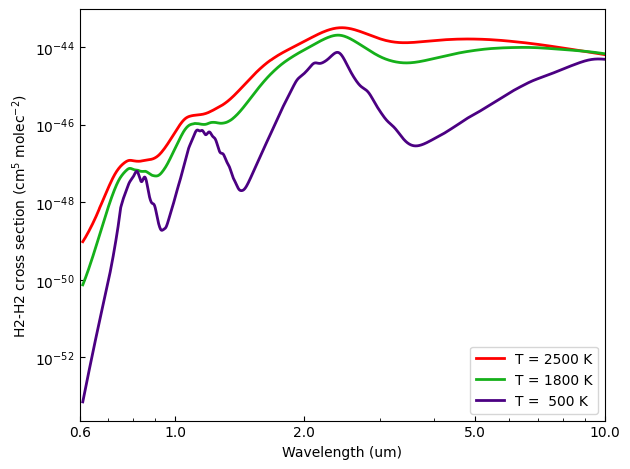

In [4]:
# Calculate cross sections:
nlayers = 81
temperature = np.tile(1800.0, nlayers)
cross_section = cia.calc_cross_section(temperature)

temp_hot = np.tile(3000.0, nlayers)
cross_section_hot = cia.calc_cross_section(temp_hot)

temp_cold = np.tile(500.0, nlayers)
cross_section_cold = cia.calc_cross_section(temp_cold)


plt.figure(1)
plt.clf()
ax = plt.subplot(111)
ax.plot(wl, cross_section_hot[40], color='red', lw=2.0, label='T = 2500 K')
ax.plot(wl, cross_section[40], color='xkcd:green', lw=2.0, label='T = 1800 K')
ax.plot(wl, cross_section_cold[40], color='indigo', lw=2.0, label='T =  500 K')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Wavelength (um)')
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xticks([0.6, 1.0, 2.0, 5.0, 10.0])
ax.set_xlim(0.6, 10.0)
ax.tick_params(which='both', direction='in')
ax.set_ylabel('H2-H2 cross section (cm$^{5}$ molec$^{-2}$)')
ax.legend(loc='lower right')
plt.tight_layout()


Compute chemical abundances.


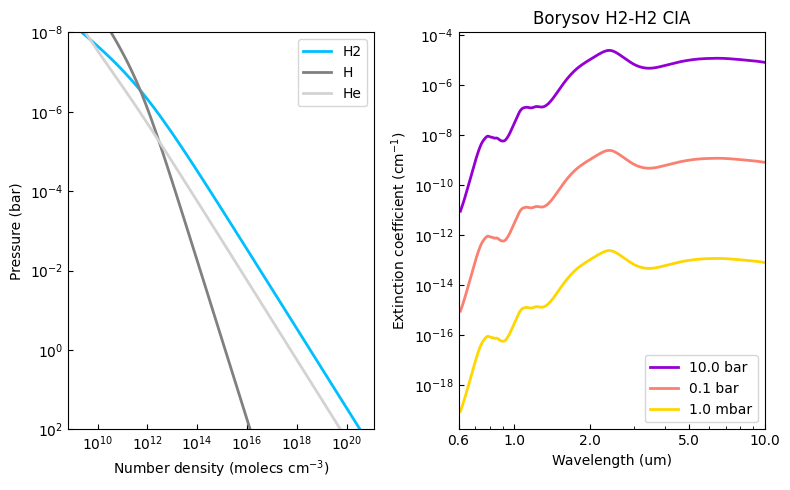

In [5]:
# Likewise, we can calculate extinction coefficient by providing a
# temperature and number density profile:

# Consider a solar-abundance isothermal atmosphere
nlayers = 81
pressure = pa.pressure('1e-8 bar', '1e2 bar', nlayers)
temperature = np.tile(1800.0, nlayers)
species = ['H2', 'H', 'He']
# Get VMRs in thermochemical equilibrium for a simple mix (only H2, H, and He)
# and their number-density profiles under IGL (molecules per cm3)
net = pa.chemistry('tea', pressure, temperature, species)
number_densities = pa.ideal_gas_density(net.vmr, pressure, temperature)
# Indices for H2,H2 number density in the atmosphere:
cia_indices = [species.index(mol) for mol in cia.species]
density = number_densities[:,cia_indices]

# Compute extinction at all layers:
extinction_coefficient = cia.calc_extinction_coefficient(
    temperature,
    density,
)

# Compute extinction at a single layer:
ec_single = cia.calc_extinction_coefficient(
    temperature[40],
    density[40],
)


# Show profiles:
cols = ['deepskyblue', 'gray', 'lightgray']
plt.figure(2, (8,5))
plt.clf()
ax = plt.subplot(121)
for i, spec in enumerate(species):
    ax.plot(number_densities[:,i], pressure, color=cols[i], lw=2.0, label=spec)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(np.amax(pressure), np.amin(pressure))
ax.tick_params(which='both', direction='in')
ax.set_xlabel('Number density (molecs cm$^{-3}$)')
ax.set_ylabel('Pressure (bar)')
ax.legend(loc='best')

ax = plt.subplot(122)
ax.plot(wl, extinction_coefficient[72], color='darkviolet', lw=2.0, label='10.0 bar')
ax.plot(wl, extinction_coefficient[56], color='salmon', lw=2.0, label='0.1 bar')
ax.plot(wl, ec_single, color='gold', lw=2.0, label='1.0 mbar')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Wavelength (um)')
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xticks([0.6, 1.0, 2.0, 5.0, 10.0])
ax.set_xlim(0.6, 10.0)
ax.tick_params(which='both', direction='in')
ax.set_ylabel('Extinction coefficient (cm$^{-1}$)')
ax.legend(loc='lower right')
ax.set_title('Borysov H2-H2 CIA')
plt.tight_layout()

## HITRAN CIA opacities

`pyratbay` does not provide the HITRAN CIA data, but you can get and format it with the following prompt commands:

```shell
wget https://hitran.org/data/CIA/H2-H2_2011.cia
pbay -cs hitran H2-H2_2011.cia
```

Then back in the python interpreter:

In [6]:
# Sample at our desired wavelength array:
cs_file = 'CIA_HITRAN_H2-H2_1.0-500.0um_0200-3000K.dat'
hit_cia = op.Collision_Induced(cs_file, wl=wl)


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    The tabulated wavenumber range [20.00, 10000.00] cm-1 does not
cover the whole requested wavenumber range: [999.02, 16393.44] cm-1
for cross-section file: 'CIA_HITRAN_H2-H2_1.0-500.0um_0200-3000K.dat'
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::



<div class="alert alert-info">

Note

Sampling in wavenumber beyond the table limits is OK, out-of-bounds
opacities will be extrapolated as zero.

</div>

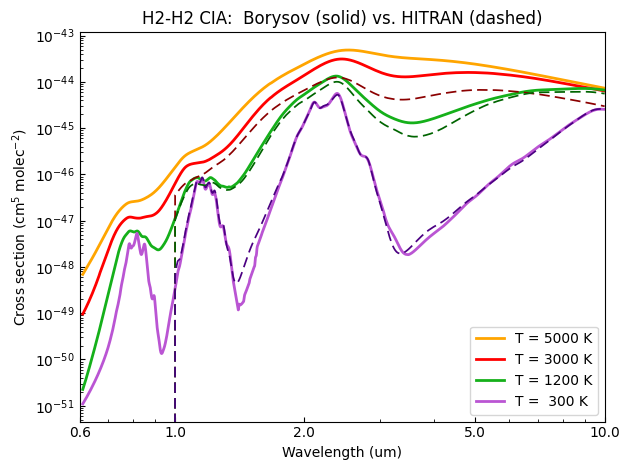

In [7]:
# Compare HITRAN and Borysov CIA cross sections:
bor_cs_0300 = cia.calc_cross_section(temperature=300.0)
bor_cs_1200 = cia.calc_cross_section(temperature=1200.0)
bor_cs_3000 = cia.calc_cross_section(temperature=3000.0)
bor_cs_5000 = cia.calc_cross_section(temperature=4500.0)

hit_cs_0300 = hit_cia.calc_cross_section(temperature=300.0)
hit_cs_1200 = hit_cia.calc_cross_section(temperature=1200.0)
hit_cs_3000 = hit_cia.calc_cross_section(temperature=3000.0)
# Note, HITRAN CIA's don't go beyond 3000K
# Sampling in temperature beyond the table limits is not OK,
# extrapolation its not good science

plt.figure(4)
plt.clf()
ax = plt.subplot(111)
ax.plot(wl, bor_cs_5000, color='orange', lw=2.0, label='T = 5000 K')
ax.plot(wl, bor_cs_3000, color='red', lw=2.0, label='T = 3000 K')
ax.plot(wl, bor_cs_1200, color='xkcd:green', lw=2.0, label='T = 1200 K')
ax.plot(wl, bor_cs_0300, color='mediumorchid', lw=2.0, label='T =  300 K')

ax.plot(wl, hit_cs_3000, color='darkred', lw=1.25, dashes=(6,3))
ax.plot(wl, hit_cs_1200, color='darkgreen', lw=1.25, dashes=(6,3))
ax.plot(wl, hit_cs_0300, color='indigo', lw=1.25, dashes=(6,3))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Wavelength (um)')
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xticks([0.6, 1.0, 2.0, 5.0, 10.0])
ax.set_xlim(0.6, 10.0)
ax.tick_params(which='both', direction='in')
ax.set_ylabel('Cross section (cm$^{5}$ molec$^{-2}$)')
ax.legend(loc='lower right')
ax.set_title('H2-H2 CIA:  Borysov (solid) vs. HITRAN (dashed)')
plt.tight_layout()

## H2-He CIA opacities

Download and format the HITRAN H2-He CIA data with the following prompt commands:

```shell
wget https://hitran.org/data/CIA/H2-He_2011.cia
pbay -cs hitran H2-He_2011.cia
```

And back in the python interpreter:

In [8]:
# Initialize CIA models:
wl_min = 0.5
wl_max = 10.01
resolution = 15000.0
new_wl = ps.constant_resolution_spectrum(wl_min, wl_max, resolution)

# Load up Borysov CIA tabulated data for H2-He:
cs_file = f'{pc.ROOT}/pyratbay/data/CIA/CIA_Borysow_H2He_0050-7000K_0.5-031um.dat'
bor_H2He_cia = op.Collision_Induced(cs_file, wl=new_wl)

# Load up HITRAN CIA tabulated data for H2-He:
cs_file = 'CIA_HITRAN_H2-He_0.5-500.0um_0200-9900K.dat'
hit_H2He_cia = op.Collision_Induced(cs_file, wl=new_wl)

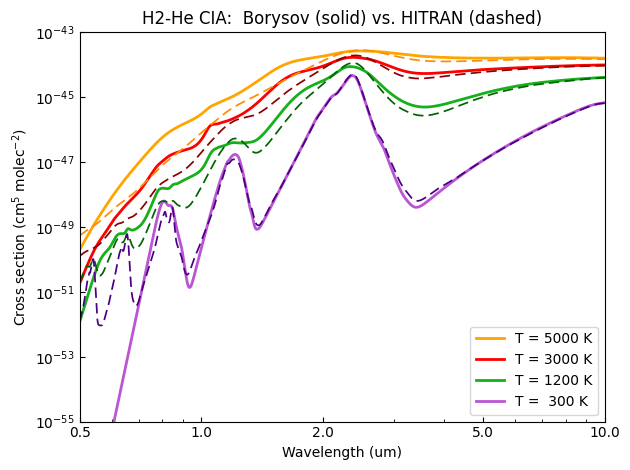

In [9]:
# Compare HITRAN and Borysov CIA cross sections:
hit_cs_0300 = hit_H2He_cia.calc_cross_section(temperature=300.0)
hit_cs_1200 = hit_H2He_cia.calc_cross_section(temperature=1200.0)
hit_cs_3000 = hit_H2He_cia.calc_cross_section(temperature=3000.0)
hit_cs_5000 = hit_H2He_cia.calc_cross_section(temperature=5000.0)

bor_cs_0300 = bor_H2He_cia.calc_cross_section(temperature=300.0)
bor_cs_1200 = bor_H2He_cia.calc_cross_section(temperature=1200.0)
bor_cs_3000 = bor_H2He_cia.calc_cross_section(temperature=3000.0)
bor_cs_5000 = bor_H2He_cia.calc_cross_section(temperature=5000.0)


plt.figure(5)
plt.clf()
ax = plt.subplot(111)
ax.plot(new_wl, bor_cs_5000, color='orange', lw=2.0, label='T = 5000 K')
ax.plot(new_wl, bor_cs_3000, color='red', lw=2.0, label='T = 3000 K')
ax.plot(new_wl, bor_cs_1200, color='xkcd:green', lw=2.0, label='T = 1200 K')
ax.plot(new_wl, bor_cs_0300, color='mediumorchid', lw=2.0, label='T =  300 K')
ax.plot(new_wl, hit_cs_5000, color='darkorange', lw=1.25, dashes=(6,3))
ax.plot(new_wl, hit_cs_3000, color='darkred', lw=1.25, dashes=(6,3))
ax.plot(new_wl, hit_cs_1200, color='darkgreen', lw=1.25, dashes=(6,3))
ax.plot(new_wl, hit_cs_0300, color='indigo', lw=1.25, dashes=(6,3))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Wavelength (um)')
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xticks([0.3, 0.5, 1.0, 2.0, 5.0, 10.0])
ax.set_xlim(0.5, 10.0)
ax.set_ylim(1e-55, 1e-43)
ax.tick_params(which='both', direction='in')
ax.set_ylabel('Cross section (cm$^{5}$ molec$^{-2}$)')
ax.legend(loc='lower right')
ax.set_title('H2-He CIA:  Borysov (solid) vs. HITRAN (dashed)')
plt.tight_layout()